## This notebook presents the reproducible procedure that we followed in comparing the performance of Hybrid Quantum Neural Networks-Parallel and Classical Convolutional Neural Networks on the IDRID dataset. The IDRID dataset is a diabetic-retinopathy dataset with 516 fundus images. The dataset was produced in India and is labeled with five-category classification (no diabetic retinopathy, mild diabetic retinopathy, moderate diabetic retinopathy, severe diabetic retinopathy, and proliferative diabetic retinopathy).

### Installing and Importing Dependencies

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 104.8 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
import random
from itertools import cycle

os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models_QNN-Parallel/"

### General Training, Validation, Testing Functions

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [ ]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [ ]:
import pickle

def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed, quantum=False):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_loss = float('inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0
  early_stopping_patience = 10

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_without_improvement = 0  # Reset counter

      else:
            epochs_without_improvement += 1

      if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


  model.load_state_dict(best_model_weights)

  if quantum:
    torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))
  else:
    torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))

  metrics = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "train_aucs": train_aucs,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_aucs": val_aucs
    }

  with open(os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}_metrics.pkl'), 'wb') as f:
        pickle.dump(metrics, f)

  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [ ]:
import math
import matplotlib.pyplot as plt

def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
    plt.style.use("default")

    loss_min = math.floor(min(min(quantum_loss), min(normal_loss)) * 10) / 10
    loss_max = math.ceil(max(max(quantum_loss), max(normal_loss)) * 10) / 10

    acc_min = math.floor(min(min(quantum_acc), min(normal_acc)) * 10) / 10
    acc_max = math.ceil(max(max(quantum_acc), max(normal_acc)) * 10) / 10

    auc_min = math.floor(min(min(quantum_auc), min(normal_auc)) * 10) / 10
    auc_max = math.ceil(max(max(quantum_auc), max(normal_auc)) * 10) / 10

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_loss, label="With quantum layer")
    plt.plot(normal_loss, label="Without quantum layer")
    plt.ylabel("Loss")
    plt.ylim([loss_min, loss_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_acc, label="With quantum layer")
    plt.plot(normal_acc, label="Without quantum layer")
    plt.ylabel("Accuracy")
    plt.ylim([acc_min, acc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Accuracy vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_auc, label="With quantum layer")
    plt.plot(normal_auc, label="Without quantum layer")
    plt.ylabel("ROCAUC")
    plt.ylim([auc_min, auc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("ROCAUC vs. Epoch")
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import label_binarize
from itertools import cycle


def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)


            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)
            # Normal model predictions
            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds_hybrid = np.array(all_preds_hybrid)
    all_preds_normal = np.array(all_preds_normal)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)


    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)


    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')


    if num_classes == 2:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, pos_label=1)
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, pos_label=1)
        precision_normal = precision_score(all_labels, all_preds_normal, pos_label=1)
        recall_normal = recall_score(all_labels, all_preds_normal, pos_label=1)
    else:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, average='weighted')
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, average='weighted')
        precision_normal = precision_score(all_labels, all_preds_normal, average='weighted')
        recall_normal = recall_score(all_labels, all_preds_normal, average='weighted')


    hybrid_aucs = []
    normal_aucs = []

    if num_classes == 2:

        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)


        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUROC = {auc_hybrid:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Hybrid Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curve for the Normal Model
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUROC = {auc_normal:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Normal Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()



        print("\nHybrid Model Metrics:")
        print(f'Accuracy: {accuracy_hybrid:.4f}')
        print(f'F1 Score: {f1_hybrid:.4f}')
        print(f'Precision: {precision_hybrid:.4f}')
        print(f'Recall: {recall_hybrid:.4f}')
        print(f'AUROC: {auc_hybrid}')

        print("\nNormal Model Metrics:")
        print(f'Accuracy: {accuracy_normal:.4f}')
        print(f'F1 Score: {f1_normal:.4f}')
        print(f'Precision: {precision_normal:.4f}')
        print(f'Recall: {recall_normal:.4f}')
        print(f'AUROC: {auc_normal} \n')

        cm_hybrid = confusion_matrix(all_labels, all_preds_hybrid)


        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix: Hybrid Model (Avg AUC = {auc_hybrid})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        cm_normal = confusion_matrix(all_labels, all_preds_normal)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix: Classical Model (Avg AUC = {auc_normal})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()


    else:  # Multi-class Classification

        all_labels_binarized = label_binarize(all_labels, classes=np.arange(num_classes))

        # Define a color cycle for plotting
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
        # Plot ROC curves for the Hybrid Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_hybrid[:, i])
            roc_auc = auc(fpr, tpr)
            hybrid_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Hybrid Model')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curves for the Normal Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_normal[:, i])
            roc_auc = auc(fpr, tpr)
            normal_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Normal Model')
        plt.legend(loc='lower right')
        plt.show()



        normal_auc = f"{sum(normal_aucs) / len(normal_aucs):.4f}"
        hybrid_auc = f"{sum(hybrid_aucs) / len(hybrid_aucs):.4f}"

        print("\nHybrid Model Metrics:")
        print(f'Accuracy: {accuracy_hybrid:.4f}')
        print(f'F1 Score: {f1_hybrid:.4f}')
        print(f'Precision: {precision_hybrid:.4f}')
        print(f'Recall: {recall_hybrid:.4f}')
        print(f'AUROC: {hybrid_auc}')

        print("\nNormal Model Metrics:")
        print(f'Accuracy: {accuracy_normal:.4f}')
        print(f'F1 Score: {f1_normal:.4f}')
        print(f'Precision: {precision_normal:.4f}')
        print(f'Recall: {recall_normal:.4f}')
        print(f'AUROC: {normal_auc} \n')

        cm_hybrid = confusion_matrix(all_labels, all_preds_hybrid)


        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix: Hybrid Model (Avg AUC = {hybrid_auc})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        cm_normal = confusion_matrix(all_labels, all_preds_normal)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix: Classical Model (Avg AUC = {normal_auc})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def load_data(batch_size, dataset):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

  return train_loader, valid_loader, test_loader

### Classical CNN Model Construction and General Methods

In [ ]:
class NormalModel(nn.Module):
    def __init__(self, num_classes):
        super(NormalModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 56 * 56, 120)
        self.fc2 = nn.Linear(120, 20)
        self.fc3 = nn.Linear(20, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Hybrid Quantum Neural Network Construction

In [ ]:
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# Define the QLayer
n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits)}


In [ ]:
class QuantumHybridModel(nn.Module):
    def __init__(self, num_classes):
      super(QuantumHybridModel, self).__init__()
      self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)
      self.bn1 = nn.BatchNorm2d(16)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
      self.bn2 = nn.BatchNorm2d(32)
      self.qlayer1 = qml.qnn.TorchLayer(qnode, weight_shapes)
      self.qlayer2 = qml.qnn.TorchLayer(qnode, weight_shapes)
      self.qlayer3 = qml.qnn.TorchLayer(qnode, weight_shapes)
      self.qlayer4 = qml.qnn.TorchLayer(qnode, weight_shapes)
      self.fc1 = nn.Linear(32 * 56 * 56, 120)
      self.fc2 = nn.Linear(120, 20)
      self.fc3 = nn.Linear(20, num_classes)

    def forward(self, x):
        # Propagate the input through the CNN layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)
        # Pass the output to the quantum layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x_1, x_2, x_3, x_4 = torch.split(x, 5, dim=1)
        x_1 = self.qlayer1(x_1)
        x_2 = self.qlayer2(x_2)
        x_3 = self.qlayer3(x_3)
        x_4 = self.qlayer4(x_4)
        x = torch.cat([x_1, x_2, x_3, x_4], axis=1)
        x = self.fc3(x)
        return x

# Experiments

In [ ]:
n_epochs = 100
num_classes = 5
batch_size = 32
dataset = "IDRID"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

## Seed Experiment 1

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(num_classes=5)
hybrid_model = QuantumHybridModel(num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
model.to(device)
hybrid_model.to(device)

Experiment with Seed 30:


QuantumHybridModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (qlayer1): <Quantum Torch Layer: func=qnode>
  (qlayer2): <Quantum Torch Layer: func=qnode>
  (qlayer3): <Quantum Torch Layer: func=qnode>
  (qlayer4): <Quantum Torch Layer: func=qnode>
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
)

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5747, Training Accuracy: 27.56%, Training AUROC: 0.5144
Validation Loss: 1.4776, Validation Accuracy: 44.30%, Validation AUROC: 0.5356
Epoch [2/100]
Training Loss: 1.4563, Training Accuracy: 36.04%, Training AUROC: 0.5888
Validation Loss: 1.4438, Validation Accuracy: 43.04%, Validation AUROC: 0.5666
Epoch [3/100]
Training Loss: 1.3963, Training Accuracy: 39.93%, Training AUROC: 0.6413
Validation Loss: 1.3571, Validation Accuracy: 49.37%, Validation AUROC: 0.5696
Epoch [4/100]
Training Loss: 1.3572, Training Accuracy: 43.11%, Training AUROC: 0.6801
Validation Loss: 1.3775, Validation Accuracy: 40.51%, Validation AUROC: 0.5865
Epoch [5/100]
Training Loss: 1.3226, Training Accuracy: 45.23%, Training AUROC: 0.7091
Validation Loss: 1.3540, Validation Accuracy: 41.77%, Validation AUROC: 0.6161
Epoch [6/100]
Training Loss: 1.2928, Training Accuracy: 46.29%, Training AUROC: 0.7327
Validation Loss: 1.3360, Validation Accuracy: 55.70%, Validation AUROC: 0.6171
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed,
    quantum=True
)

Epoch [1/100]
Training Loss: 1.5671, Training Accuracy: 31.80%, Training AUROC: 0.5045
Validation Loss: 1.5610, Validation Accuracy: 31.65%, Validation AUROC: 0.5972
Epoch [2/100]
Training Loss: 1.5506, Training Accuracy: 31.80%, Training AUROC: 0.5552
Validation Loss: 1.5532, Validation Accuracy: 31.65%, Validation AUROC: 0.5406
Epoch [3/100]
Training Loss: 1.5454, Training Accuracy: 31.80%, Training AUROC: 0.5961
Validation Loss: 1.5474, Validation Accuracy: 31.65%, Validation AUROC: 0.5531
Epoch [4/100]
Training Loss: 1.5587, Training Accuracy: 31.80%, Training AUROC: 0.5744
Validation Loss: 1.5459, Validation Accuracy: 31.65%, Validation AUROC: 0.5135
Epoch [5/100]
Training Loss: 1.5547, Training Accuracy: 31.80%, Training AUROC: 0.5402
Validation Loss: 1.5675, Validation Accuracy: 31.65%, Validation AUROC: 0.4350
Epoch [6/100]
Training Loss: 1.5518, Training Accuracy: 33.22%, Training AUROC: 0.5395
Validation Loss: 1.5501, Validation Accuracy: 31.65%, Validation AUROC: 0.4387
Epoc

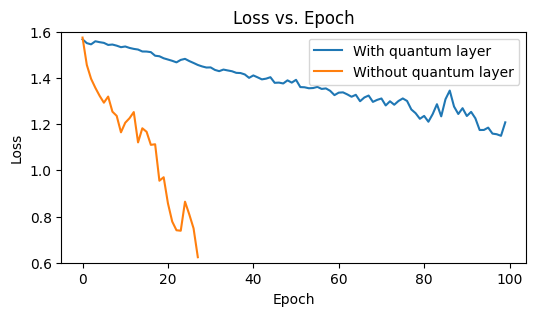

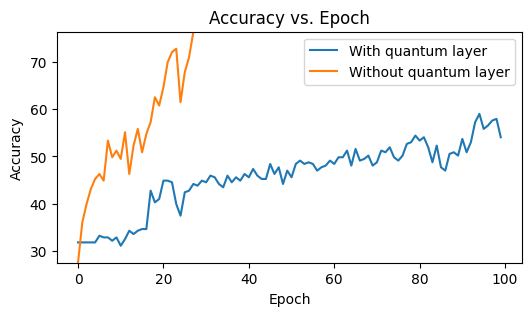

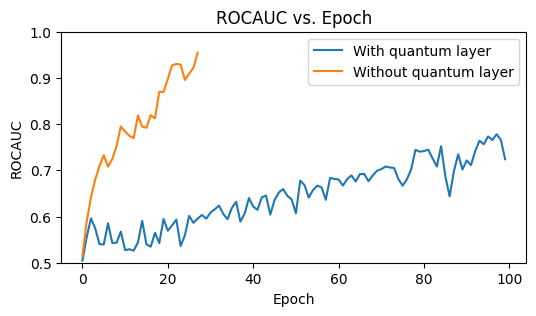

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

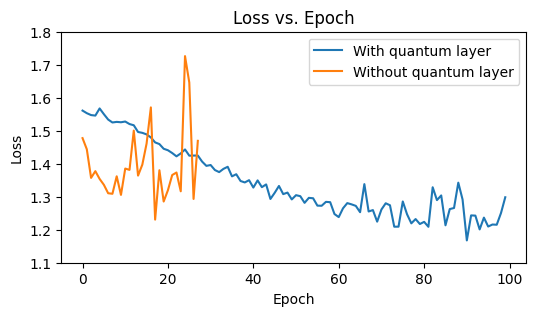

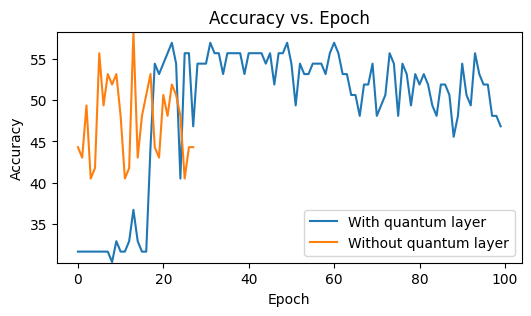

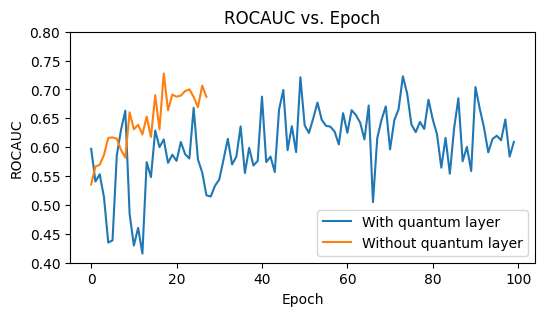

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


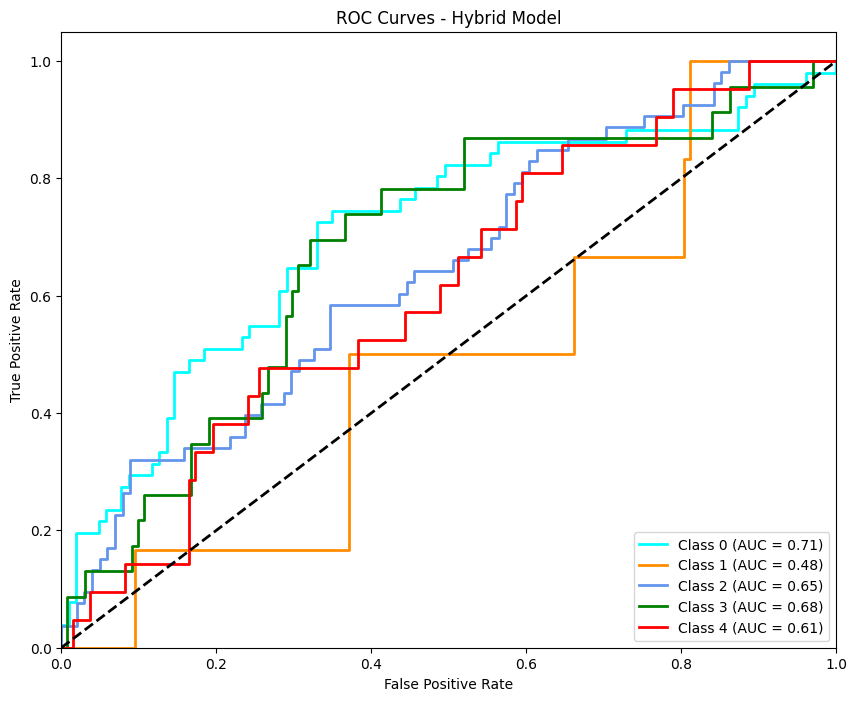

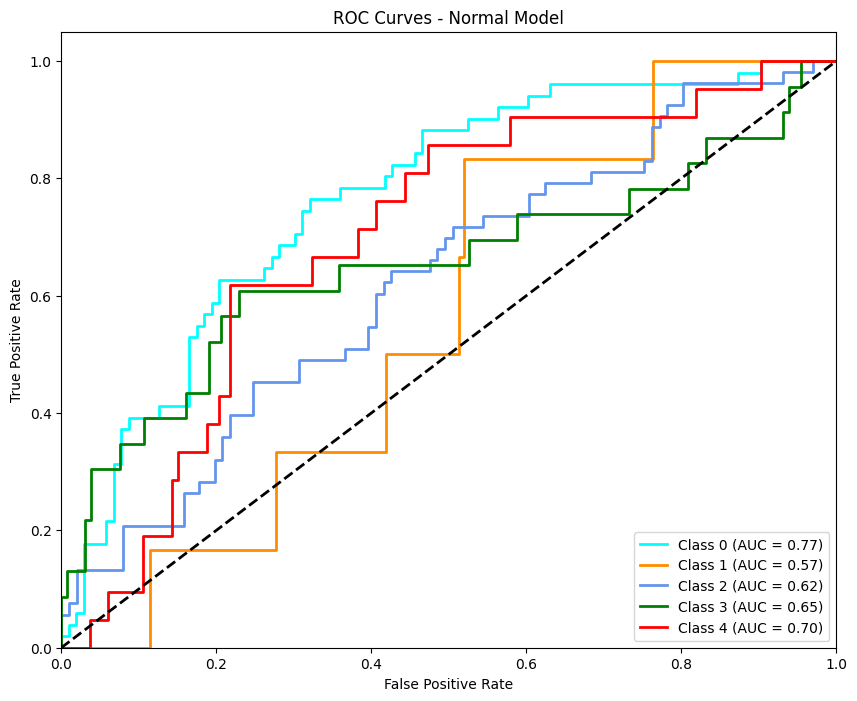


Hybrid Model Metrics:
Accuracy: 0.4351
F1 Score: 0.3681
Precision: 0.3730
Recall: 0.4351
AUROC: 0.6252

Normal Model Metrics:
Accuracy: 0.4221
F1 Score: 0.4009
Precision: 0.4041
Recall: 0.4221
AUROC: 0.6616 



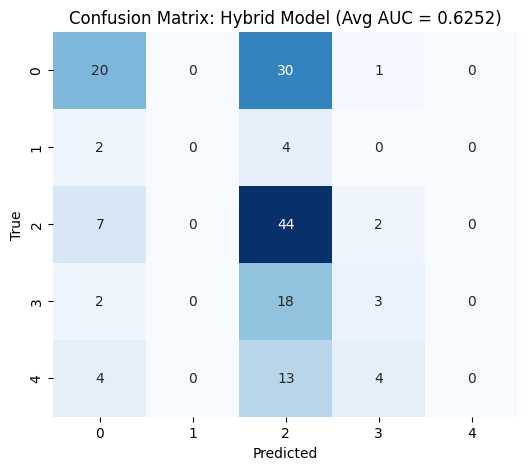

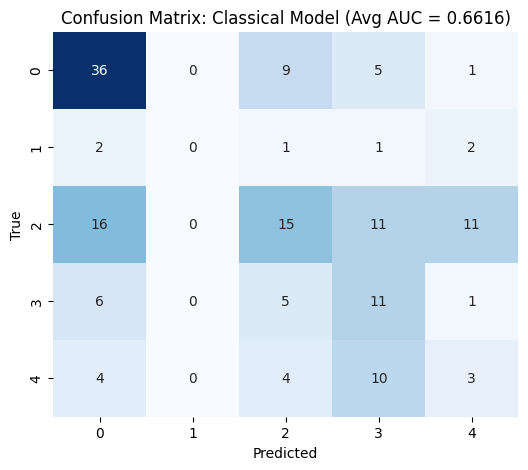

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 2

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(num_classes=5)
hybrid_model = QuantumHybridModel(num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
model.to(device)
hybrid_model.to(device)

Experiment with Seed 70:


QuantumHybridModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (qlayer1): <Quantum Torch Layer: func=qnode>
  (qlayer2): <Quantum Torch Layer: func=qnode>
  (qlayer3): <Quantum Torch Layer: func=qnode>
  (qlayer4): <Quantum Torch Layer: func=qnode>
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
)

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5599, Training Accuracy: 33.22%, Training AUROC: 0.5050
Validation Loss: 1.5445, Validation Accuracy: 20.25%, Validation AUROC: 0.6169
Epoch [2/100]
Training Loss: 1.4382, Training Accuracy: 41.34%, Training AUROC: 0.5784
Validation Loss: 1.4199, Validation Accuracy: 51.90%, Validation AUROC: 0.6062
Epoch [3/100]
Training Loss: 1.3744, Training Accuracy: 43.11%, Training AUROC: 0.6636
Validation Loss: 1.4271, Validation Accuracy: 37.97%, Validation AUROC: 0.5982
Epoch [4/100]
Training Loss: 1.3628, Training Accuracy: 43.46%, Training AUROC: 0.6707
Validation Loss: 1.2560, Validation Accuracy: 58.23%, Validation AUROC: 0.6564
Epoch [5/100]
Training Loss: 1.2961, Training Accuracy: 49.47%, Training AUROC: 0.7246
Validation Loss: 1.3024, Validation Accuracy: 50.63%, Validation AUROC: 0.6541
Epoch [6/100]
Training Loss: 1.2682, Training Accuracy: 45.58%, Training AUROC: 0.7493
Validation Loss: 1.3275, Validation Accuracy: 40.51%, Validation AUROC: 0.6794
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed,
    quantum=True
)

Epoch [1/100]
Training Loss: 1.5802, Training Accuracy: 31.80%, Training AUROC: 0.4786
Validation Loss: 1.5701, Validation Accuracy: 31.65%, Validation AUROC: 0.4231
Epoch [2/100]
Training Loss: 1.5651, Training Accuracy: 30.74%, Training AUROC: 0.5228
Validation Loss: 1.5586, Validation Accuracy: 31.65%, Validation AUROC: 0.5797
Epoch [3/100]
Training Loss: 1.5610, Training Accuracy: 31.80%, Training AUROC: 0.5440
Validation Loss: 1.5528, Validation Accuracy: 31.65%, Validation AUROC: 0.5242
Epoch [4/100]
Training Loss: 1.5731, Training Accuracy: 31.45%, Training AUROC: 0.4873
Validation Loss: 1.5563, Validation Accuracy: 31.65%, Validation AUROC: 0.6352
Epoch [5/100]
Training Loss: 1.5645, Training Accuracy: 31.80%, Training AUROC: 0.5324
Validation Loss: 1.5707, Validation Accuracy: 31.65%, Validation AUROC: 0.4377
Epoch [6/100]
Training Loss: 1.5489, Training Accuracy: 31.80%, Training AUROC: 0.5978
Validation Loss: 1.5348, Validation Accuracy: 31.65%, Validation AUROC: 0.6398
Epoc

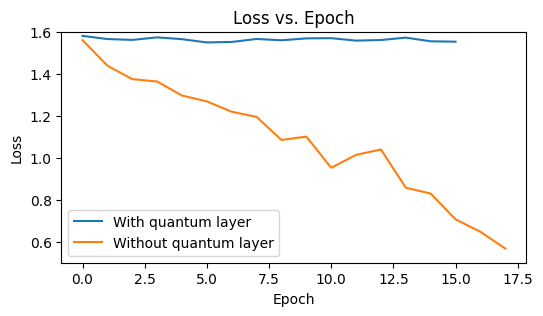

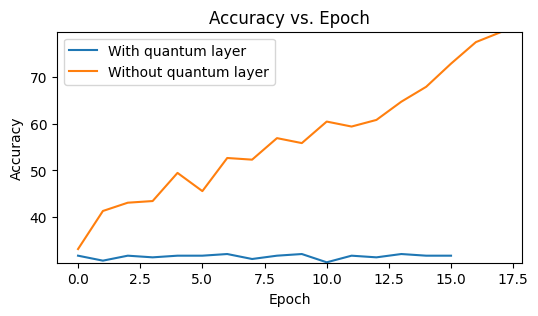

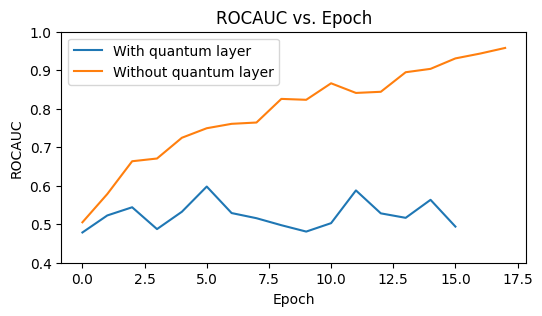

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

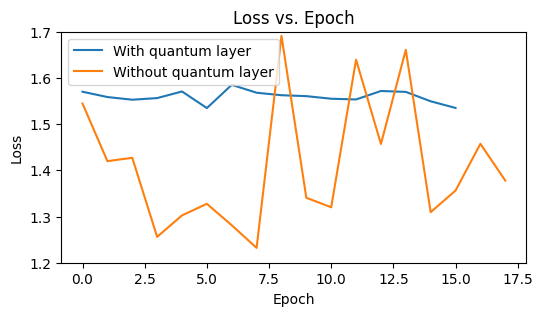

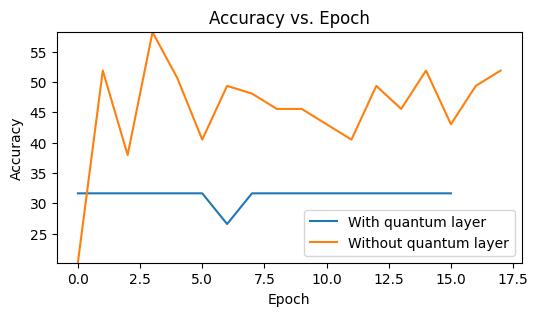

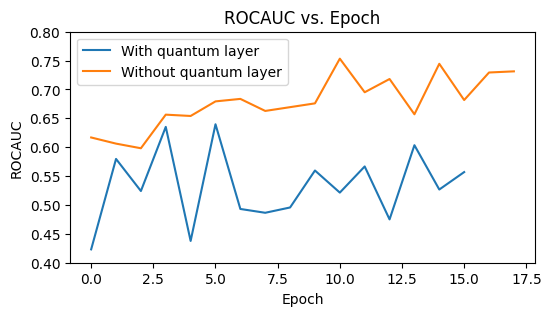

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


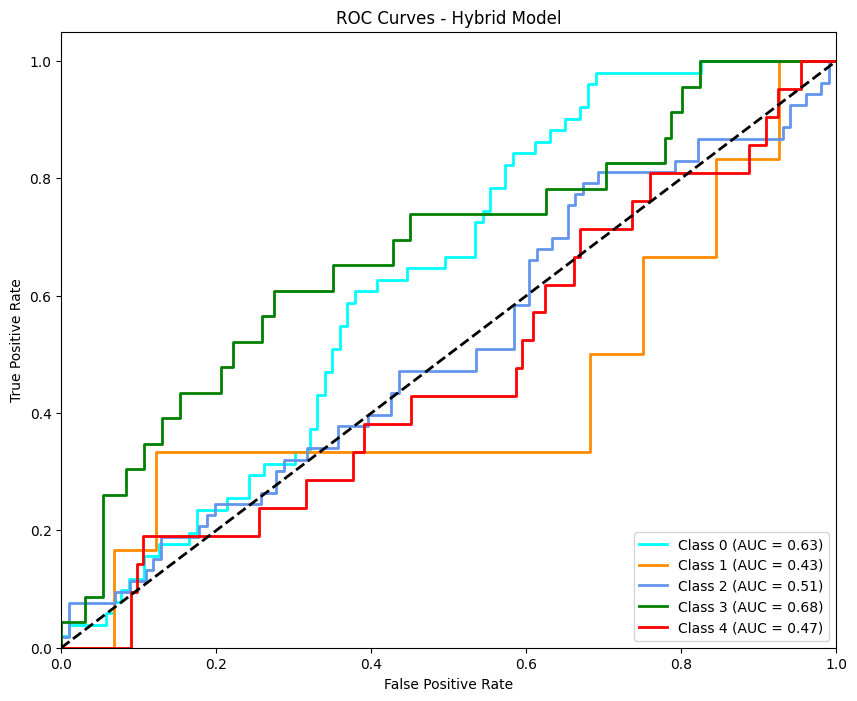

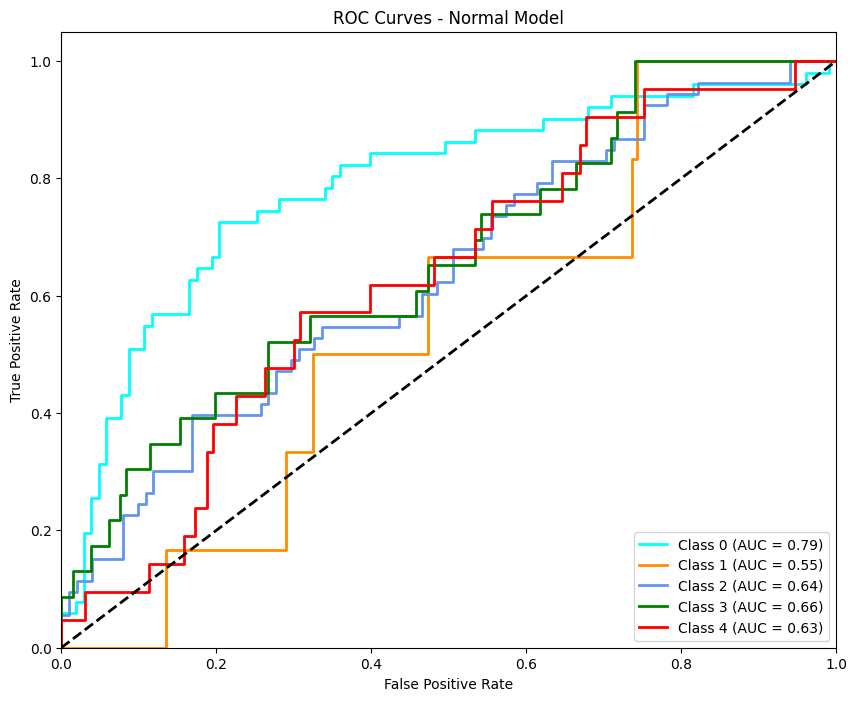


Hybrid Model Metrics:
Accuracy: 0.3442
F1 Score: 0.1762
Precision: 0.1184
Recall: 0.3442
AUROC: 0.5451

Normal Model Metrics:
Accuracy: 0.4416
F1 Score: 0.4145
Precision: 0.4219
Recall: 0.4416
AUROC: 0.6527 



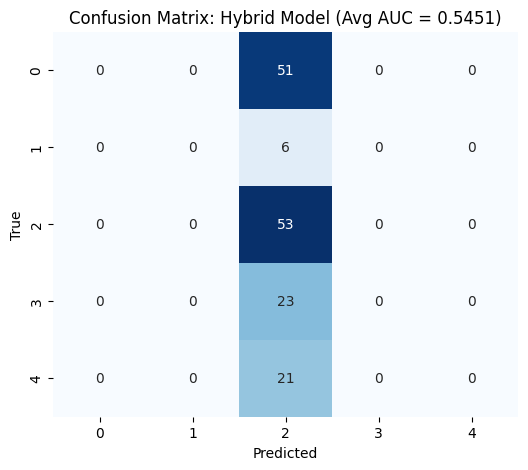

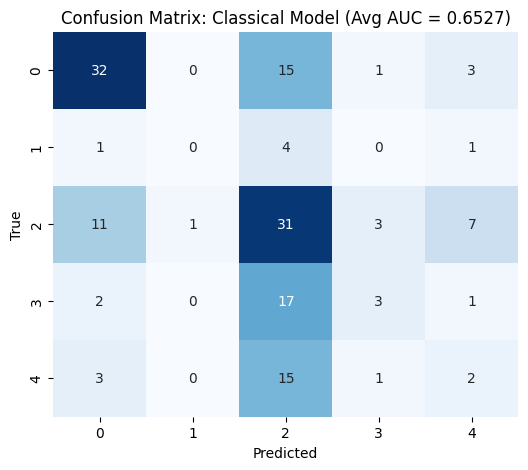

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 3

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(num_classes=5)
hybrid_model = QuantumHybridModel(num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
model.to(device)
hybrid_model.to(device)

Experiment with Seed 16:


QuantumHybridModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (qlayer1): <Quantum Torch Layer: func=qnode>
  (qlayer2): <Quantum Torch Layer: func=qnode>
  (qlayer3): <Quantum Torch Layer: func=qnode>
  (qlayer4): <Quantum Torch Layer: func=qnode>
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
)

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5763, Training Accuracy: 31.80%, Training AUROC: 0.4899
Validation Loss: 1.5164, Validation Accuracy: 35.44%, Validation AUROC: 0.6135
Epoch [2/100]
Training Loss: 1.4788, Training Accuracy: 36.04%, Training AUROC: 0.5743
Validation Loss: 1.4323, Validation Accuracy: 40.51%, Validation AUROC: 0.6347
Epoch [3/100]
Training Loss: 1.3624, Training Accuracy: 41.70%, Training AUROC: 0.6819
Validation Loss: 1.4027, Validation Accuracy: 41.77%, Validation AUROC: 0.6574
Epoch [4/100]
Training Loss: 1.3653, Training Accuracy: 46.64%, Training AUROC: 0.6795
Validation Loss: 1.3969, Validation Accuracy: 43.04%, Validation AUROC: 0.6891
Epoch [5/100]
Training Loss: 1.2999, Training Accuracy: 44.17%, Training AUROC: 0.7196
Validation Loss: 1.4401, Validation Accuracy: 35.44%, Validation AUROC: 0.6710
Epoch [6/100]
Training Loss: 1.3774, Training Accuracy: 42.76%, Training AUROC: 0.6759
Validation Loss: 1.3797, Validation Accuracy: 39.24%, Validation AUROC: 0.6772
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed,
    quantum=True
)

Epoch [1/100]
Training Loss: 1.6182, Training Accuracy: 22.97%, Training AUROC: 0.5435
Validation Loss: 1.6254, Validation Accuracy: 31.65%, Validation AUROC: 0.4095
Epoch [2/100]
Training Loss: 1.6063, Training Accuracy: 31.80%, Training AUROC: 0.5251
Validation Loss: 1.6264, Validation Accuracy: 31.65%, Validation AUROC: 0.4863
Epoch [3/100]
Training Loss: 1.6133, Training Accuracy: 30.74%, Training AUROC: 0.4897
Validation Loss: 1.5579, Validation Accuracy: 44.30%, Validation AUROC: 0.5248
Epoch [4/100]
Training Loss: 1.5984, Training Accuracy: 33.22%, Training AUROC: 0.5226
Validation Loss: 1.5887, Validation Accuracy: 39.24%, Validation AUROC: 0.5528
Epoch [5/100]
Training Loss: 1.6009, Training Accuracy: 31.80%, Training AUROC: 0.5842
Validation Loss: 1.6090, Validation Accuracy: 22.78%, Validation AUROC: 0.5471
Epoch [6/100]
Training Loss: 1.6087, Training Accuracy: 24.38%, Training AUROC: 0.5014
Validation Loss: 1.5984, Validation Accuracy: 30.38%, Validation AUROC: 0.5067
Epoc

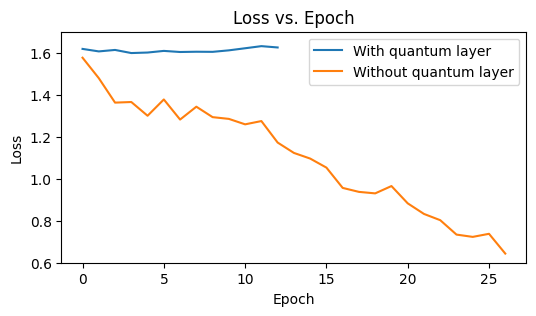

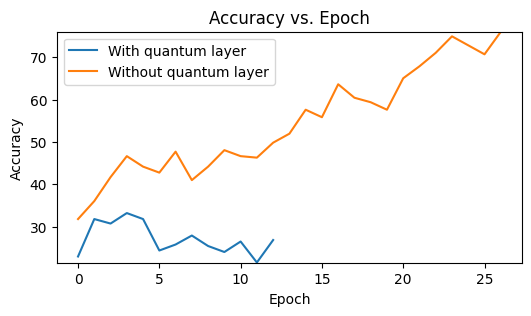

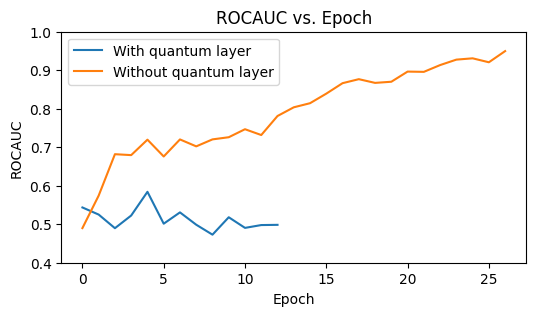

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

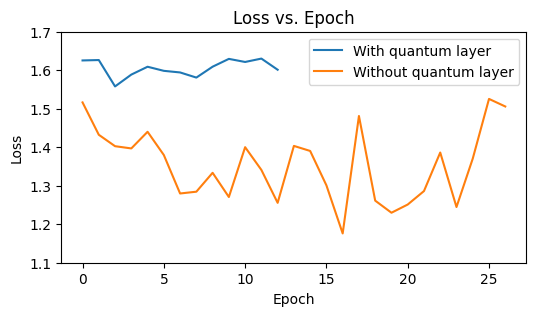

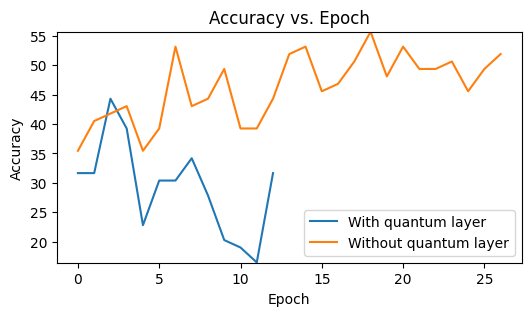

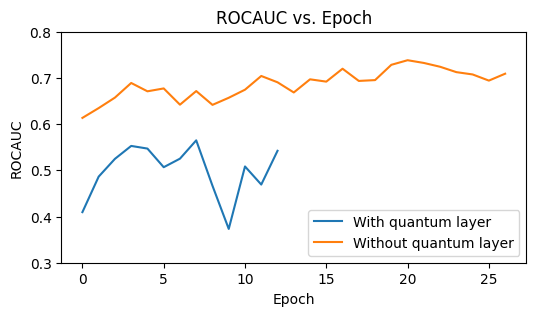

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


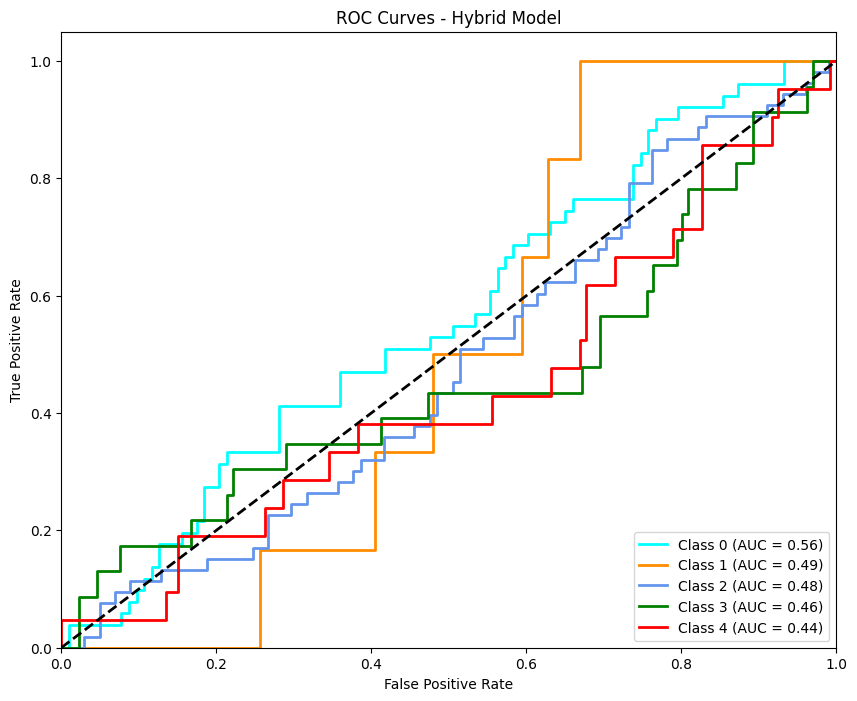

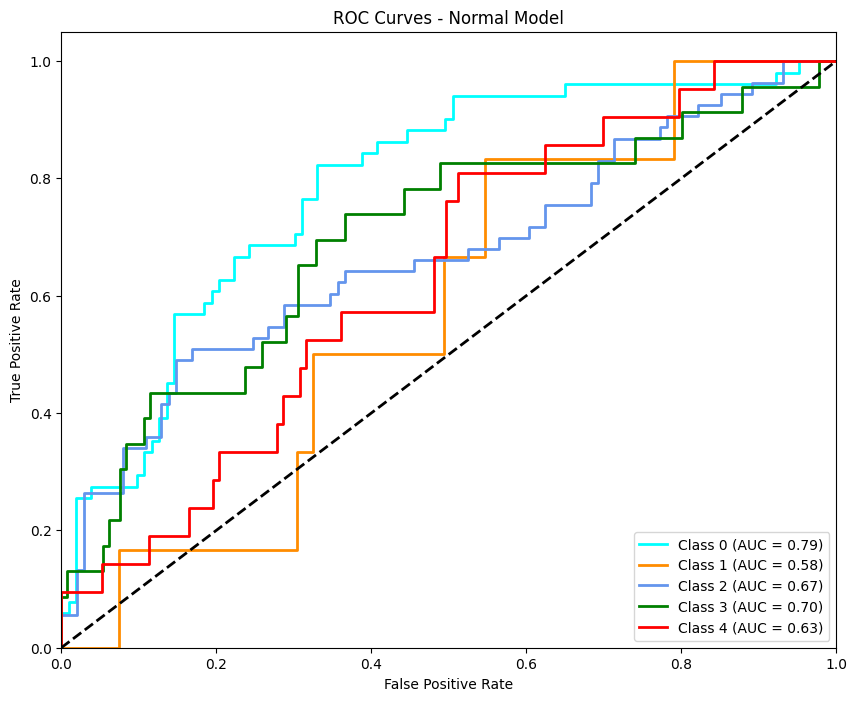


Hybrid Model Metrics:
Accuracy: 0.3312
F1 Score: 0.1793
Precision: 0.1391
Recall: 0.3312
AUROC: 0.4862

Normal Model Metrics:
Accuracy: 0.4935
F1 Score: 0.4481
Precision: 0.4127
Recall: 0.4935
AUROC: 0.6720 



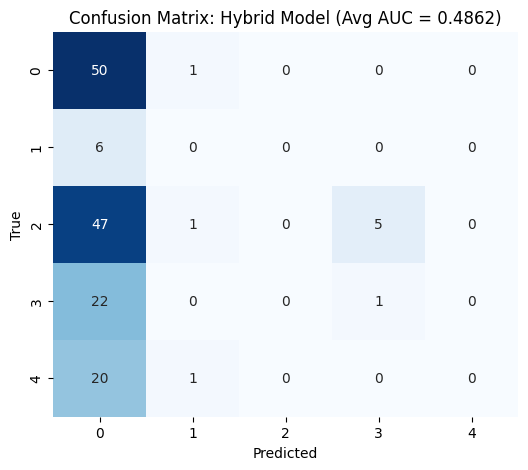

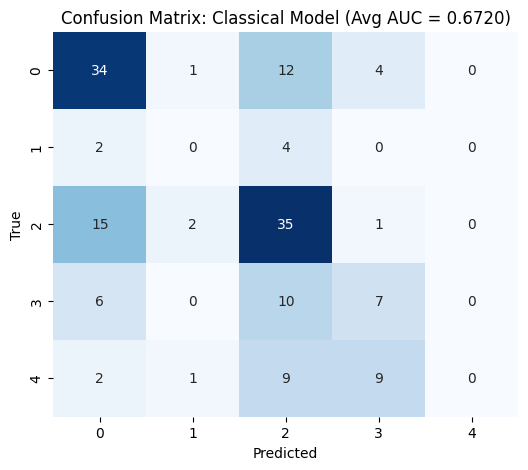

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 4

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(num_classes=5)
hybrid_model = QuantumHybridModel(num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
model.to(device)
hybrid_model.to(device)

Experiment with Seed 47:


QuantumHybridModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (qlayer1): <Quantum Torch Layer: func=qnode>
  (qlayer2): <Quantum Torch Layer: func=qnode>
  (qlayer3): <Quantum Torch Layer: func=qnode>
  (qlayer4): <Quantum Torch Layer: func=qnode>
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
)

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5220, Training Accuracy: 32.86%, Training AUROC: 0.5260
Validation Loss: 1.4193, Validation Accuracy: 46.84%, Validation AUROC: 0.5412
Epoch [2/100]
Training Loss: 1.4179, Training Accuracy: 41.70%, Training AUROC: 0.6222
Validation Loss: 1.4398, Validation Accuracy: 48.10%, Validation AUROC: 0.5522
Epoch [3/100]
Training Loss: 1.4223, Training Accuracy: 38.87%, Training AUROC: 0.6141
Validation Loss: 1.3123, Validation Accuracy: 55.70%, Validation AUROC: 0.5935
Epoch [4/100]
Training Loss: 1.3920, Training Accuracy: 44.88%, Training AUROC: 0.6498
Validation Loss: 1.3828, Validation Accuracy: 39.24%, Validation AUROC: 0.5795
Epoch [5/100]
Training Loss: 1.3987, Training Accuracy: 39.58%, Training AUROC: 0.6422
Validation Loss: 1.6227, Validation Accuracy: 35.44%, Validation AUROC: 0.5633
Epoch [6/100]
Training Loss: 1.4187, Training Accuracy: 42.76%, Training AUROC: 0.6317
Validation Loss: 1.2909, Validation Accuracy: 46.84%, Validation AUROC: 0.6370
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed,
    quantum=True
)

Epoch [1/100]
Training Loss: 1.5634, Training Accuracy: 26.15%, Training AUROC: 0.5062
Validation Loss: 1.5750, Validation Accuracy: 21.52%, Validation AUROC: 0.3528
Epoch [2/100]
Training Loss: 1.5680, Training Accuracy: 19.43%, Training AUROC: 0.4600
Validation Loss: 1.5753, Validation Accuracy: 20.25%, Validation AUROC: 0.4146
Epoch [3/100]
Training Loss: 1.5479, Training Accuracy: 31.45%, Training AUROC: 0.5680
Validation Loss: 1.5155, Validation Accuracy: 32.91%, Validation AUROC: 0.5833
Epoch [4/100]
Training Loss: 1.5533, Training Accuracy: 29.68%, Training AUROC: 0.5838
Validation Loss: 1.5504, Validation Accuracy: 29.11%, Validation AUROC: 0.5191
Epoch [5/100]
Training Loss: 1.5665, Training Accuracy: 25.80%, Training AUROC: 0.4590
Validation Loss: 1.5261, Validation Accuracy: 32.91%, Validation AUROC: 0.5589
Epoch [6/100]
Training Loss: 1.5561, Training Accuracy: 34.98%, Training AUROC: 0.5442
Validation Loss: 1.5442, Validation Accuracy: 35.44%, Validation AUROC: 0.5497
Epoc

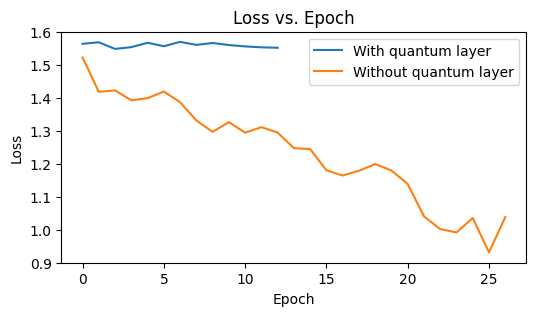

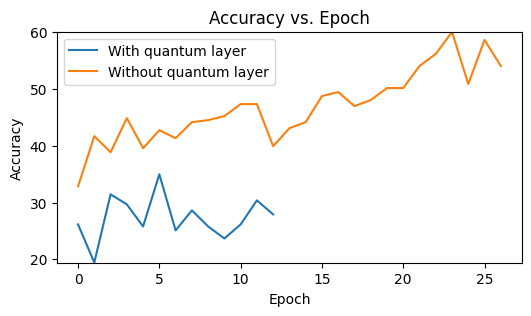

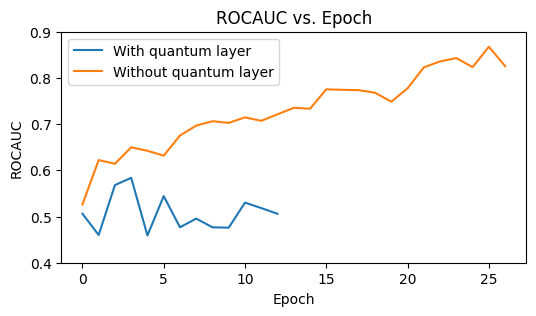

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

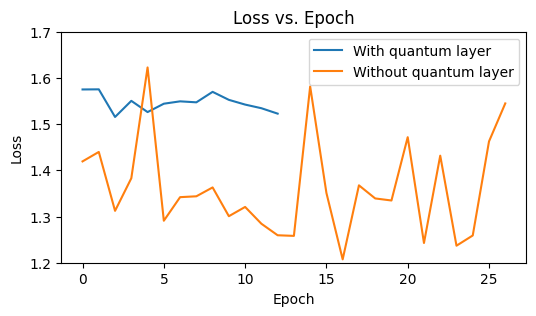

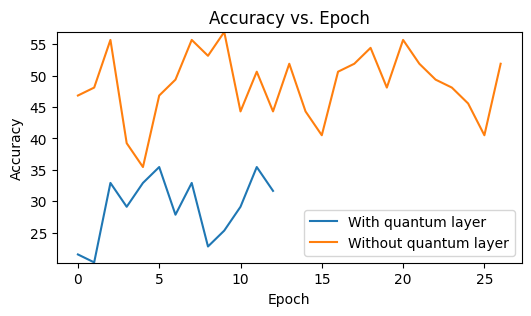

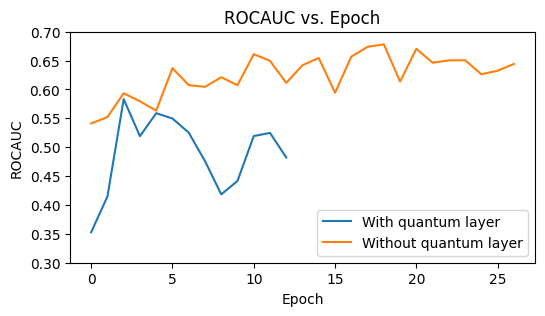

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


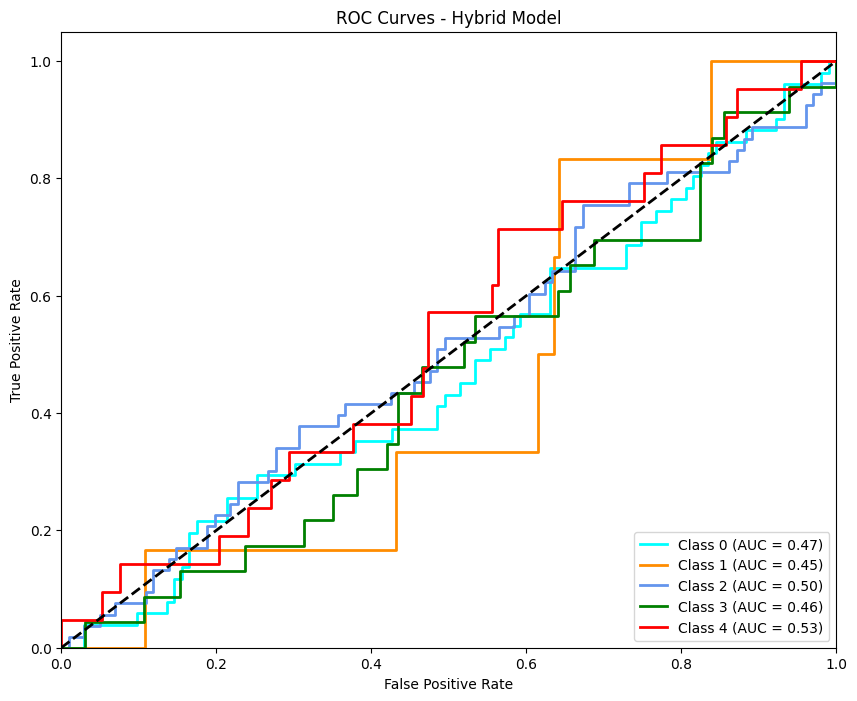

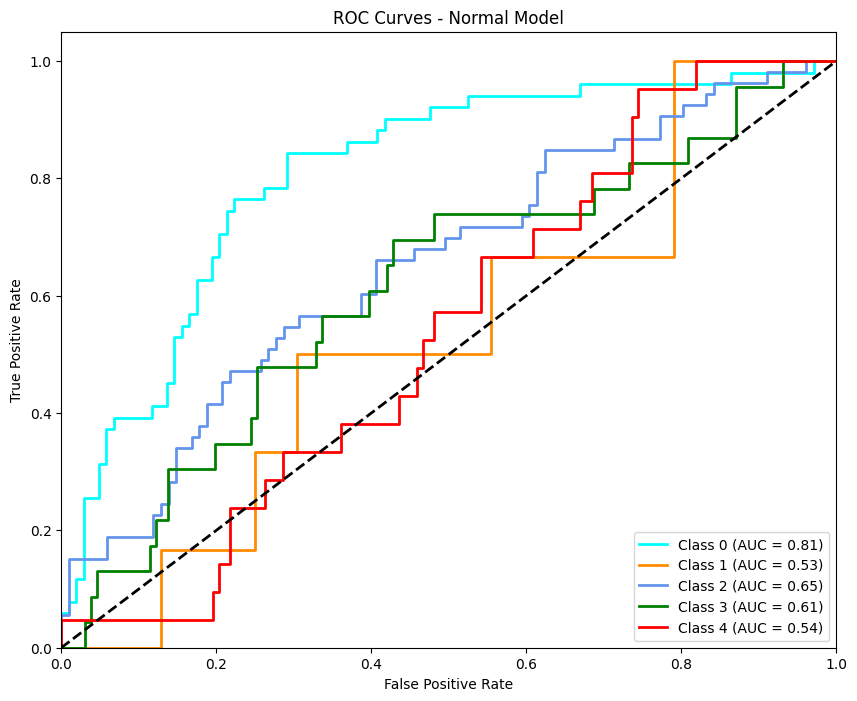


Hybrid Model Metrics:
Accuracy: 0.3182
F1 Score: 0.2760
Precision: 0.2468
Recall: 0.3182
AUROC: 0.4836

Normal Model Metrics:
Accuracy: 0.4351
F1 Score: 0.4096
Precision: 0.5271
Recall: 0.4351
AUROC: 0.6295 



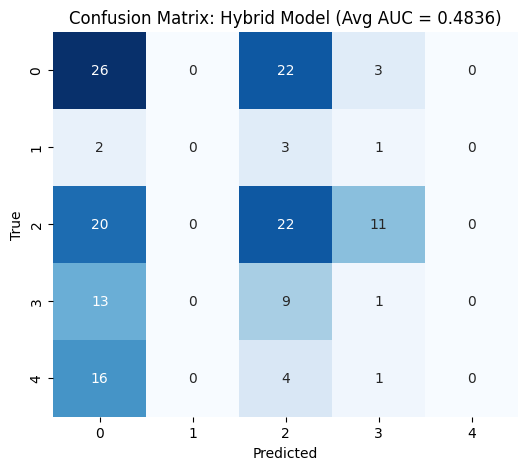

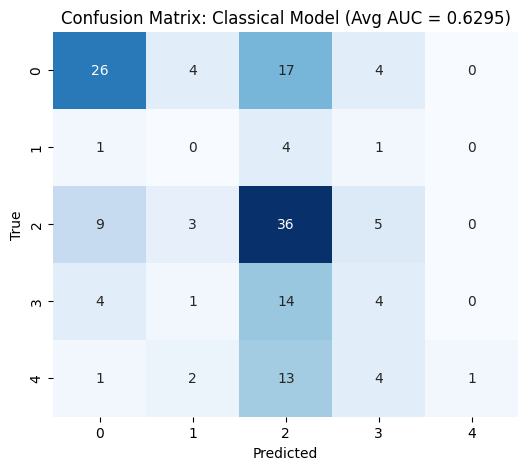

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 5

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(num_classes=5)
hybrid_model = QuantumHybridModel(num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
model.to(device)
hybrid_model.to(device)

Experiment with Seed 46:


QuantumHybridModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (qlayer1): <Quantum Torch Layer: func=qnode>
  (qlayer2): <Quantum Torch Layer: func=qnode>
  (qlayer3): <Quantum Torch Layer: func=qnode>
  (qlayer4): <Quantum Torch Layer: func=qnode>
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
)

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5387, Training Accuracy: 31.10%, Training AUROC: 0.5043
Validation Loss: 1.5166, Validation Accuracy: 37.97%, Validation AUROC: 0.5287
Epoch [2/100]
Training Loss: 1.4597, Training Accuracy: 36.75%, Training AUROC: 0.5972
Validation Loss: 1.5209, Validation Accuracy: 40.51%, Validation AUROC: 0.5987
Epoch [3/100]
Training Loss: 1.4327, Training Accuracy: 40.99%, Training AUROC: 0.6094
Validation Loss: 1.4161, Validation Accuracy: 37.97%, Validation AUROC: 0.5648
Epoch [4/100]
Training Loss: 1.4003, Training Accuracy: 38.87%, Training AUROC: 0.6286
Validation Loss: 1.3220, Validation Accuracy: 55.70%, Validation AUROC: 0.6125
Epoch [5/100]
Training Loss: 1.3752, Training Accuracy: 42.05%, Training AUROC: 0.6702
Validation Loss: 1.3455, Validation Accuracy: 45.57%, Validation AUROC: 0.6119
Epoch [6/100]
Training Loss: 1.2664, Training Accuracy: 47.70%, Training AUROC: 0.7357
Validation Loss: 1.2828, Validation Accuracy: 51.90%, Validation AUROC: 0.6502
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed,
    quantum=True
)

Epoch [1/100]
Training Loss: 1.5339, Training Accuracy: 29.68%, Training AUROC: 0.4667
Validation Loss: 1.5311, Validation Accuracy: 31.65%, Validation AUROC: 0.5219
Epoch [2/100]
Training Loss: 1.5205, Training Accuracy: 32.51%, Training AUROC: 0.4939
Validation Loss: 1.5327, Validation Accuracy: 30.38%, Validation AUROC: 0.5028
Epoch [3/100]
Training Loss: 1.5145, Training Accuracy: 36.04%, Training AUROC: 0.5203
Validation Loss: 1.4959, Validation Accuracy: 31.65%, Validation AUROC: 0.6678
Epoch [4/100]
Training Loss: 1.5115, Training Accuracy: 35.69%, Training AUROC: 0.5641
Validation Loss: 1.5026, Validation Accuracy: 21.52%, Validation AUROC: 0.4956
Epoch [5/100]
Training Loss: 1.5077, Training Accuracy: 36.04%, Training AUROC: 0.5694
Validation Loss: 1.4737, Validation Accuracy: 44.30%, Validation AUROC: 0.6168
Epoch [6/100]
Training Loss: 1.5127, Training Accuracy: 34.63%, Training AUROC: 0.5454
Validation Loss: 1.4814, Validation Accuracy: 39.24%, Validation AUROC: 0.5277
Epoc

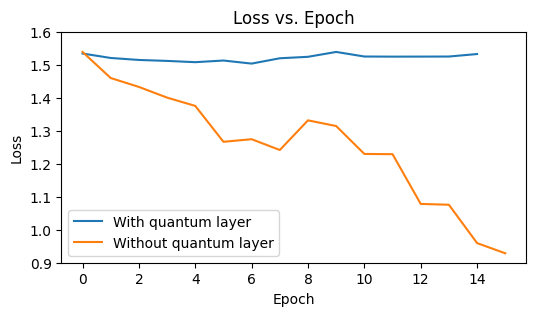

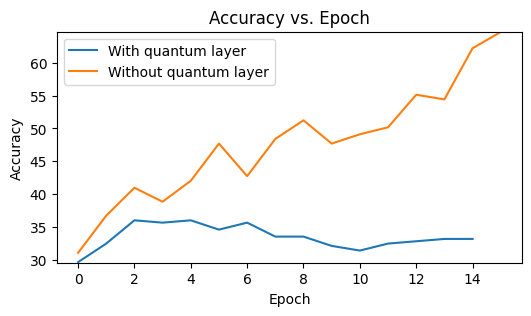

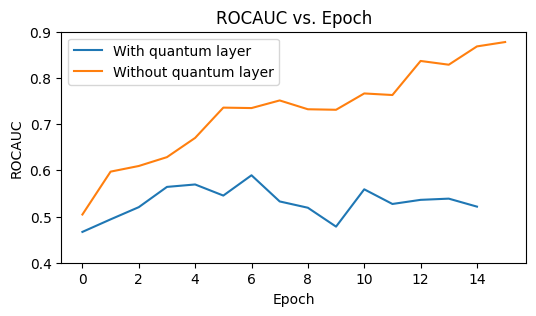

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

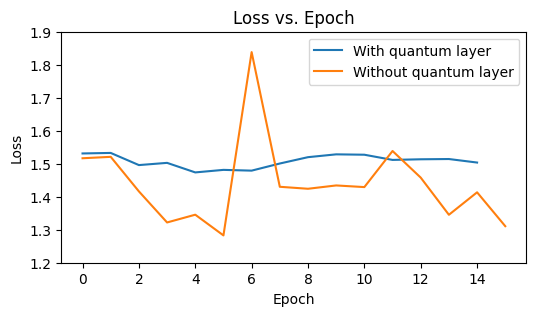

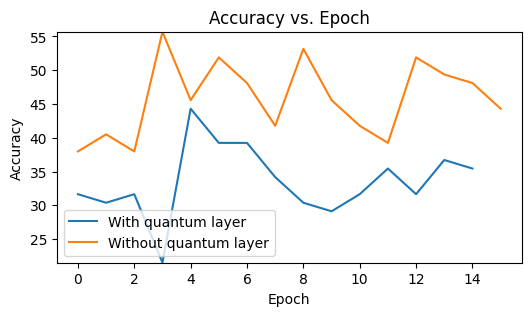

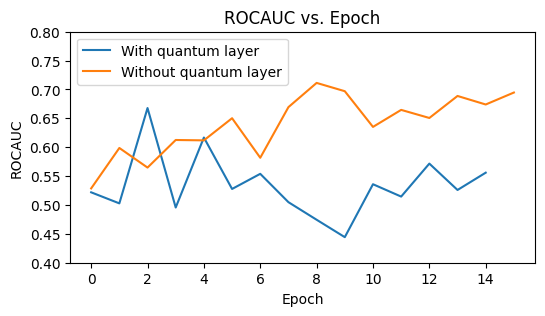

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


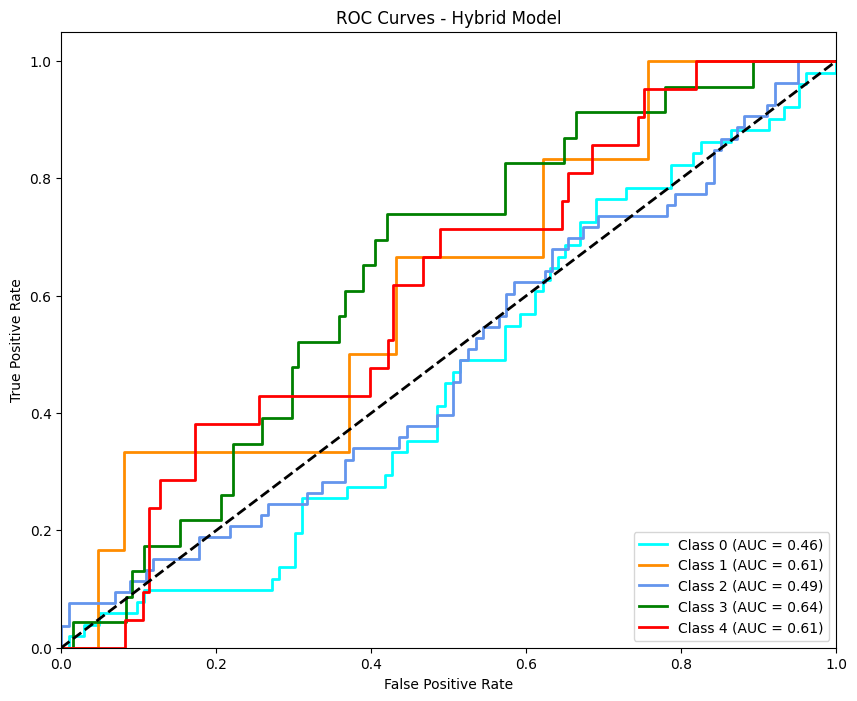

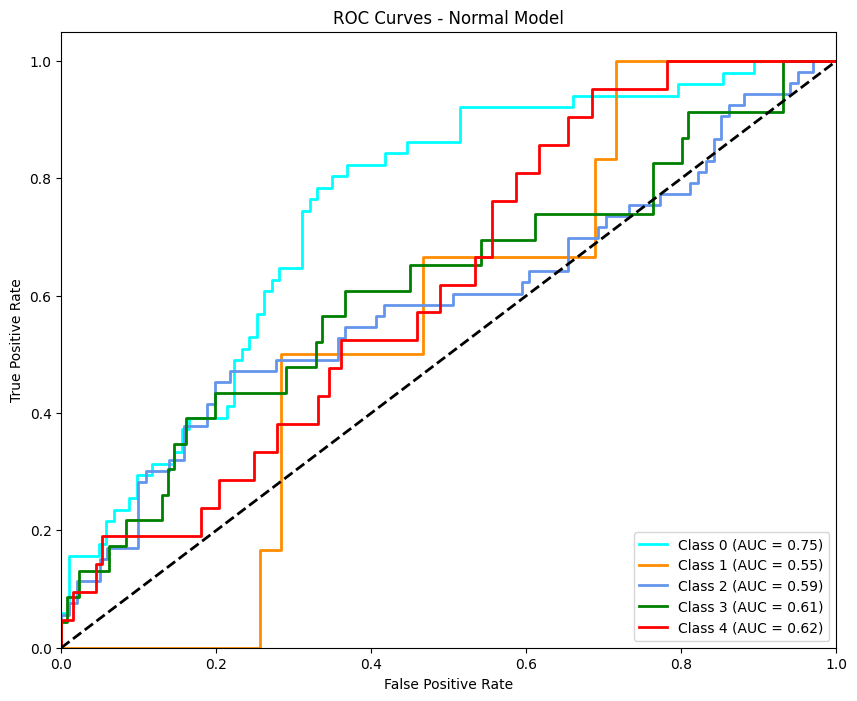


Hybrid Model Metrics:
Accuracy: 0.3442
F1 Score: 0.1771
Precision: 0.1192
Recall: 0.3442
AUROC: 0.5620

Normal Model Metrics:
Accuracy: 0.4481
F1 Score: 0.4012
Precision: 0.4070
Recall: 0.4481
AUROC: 0.6241 



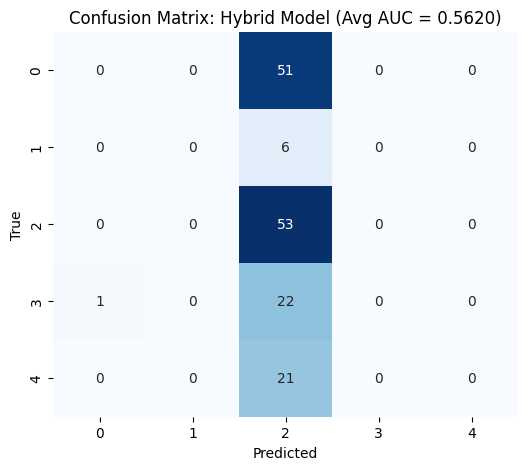

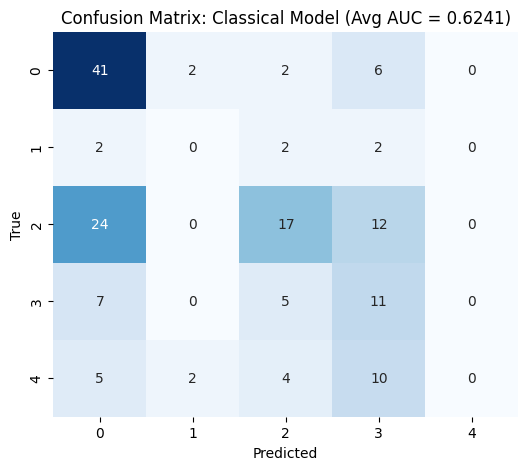

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)